# Goal

Detect keypoints and draw matches between two photos.

In [84]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [85]:
dirname = "pair3"

img_l = cv.imread(f"./data/{dirname}/left_0.jpg")
img_l = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
img_r = cv.imread(f"./data/{dirname}/right_0.jpg")
img_r = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)

In [86]:
def detect_orb_points(img) -> tuple:
    # Instantiate ORB detector
    orb = cv.ORB_create()

    # detect keyboards
    kp = orb.detect(img, None)

    # compute descriptors
    kp, des = orb.compute(img, kp)

    return kp, des

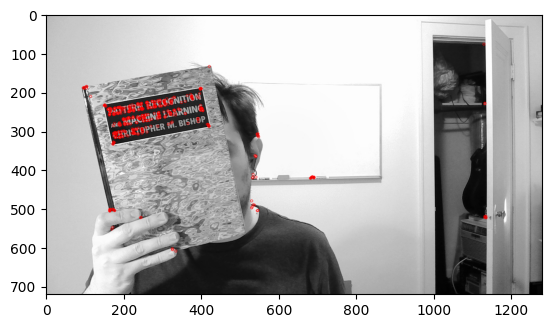

(<matplotlib.image.AxesImage at 0x2be97069a10>, None)

In [87]:
kp_l, des_l = detect_orb_points(img_l)
kp_r, des_r = detect_orb_points(img_r)

imgplt_l = cv.drawKeypoints(img_l, kp_l, None, color=(255,0,0), flags=0)
imgplt_r = cv.drawKeypoints(img_r, kp_r, None, color=(255,0,0), flags=0)

plt.imshow(imgplt_l)
plt.imshow(imgplt_r), plt.show()

In [88]:
# Instantiate BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des_l, des_r)

# Sort them by distance
matches = sorted(matches, key = lambda x: x.distance)

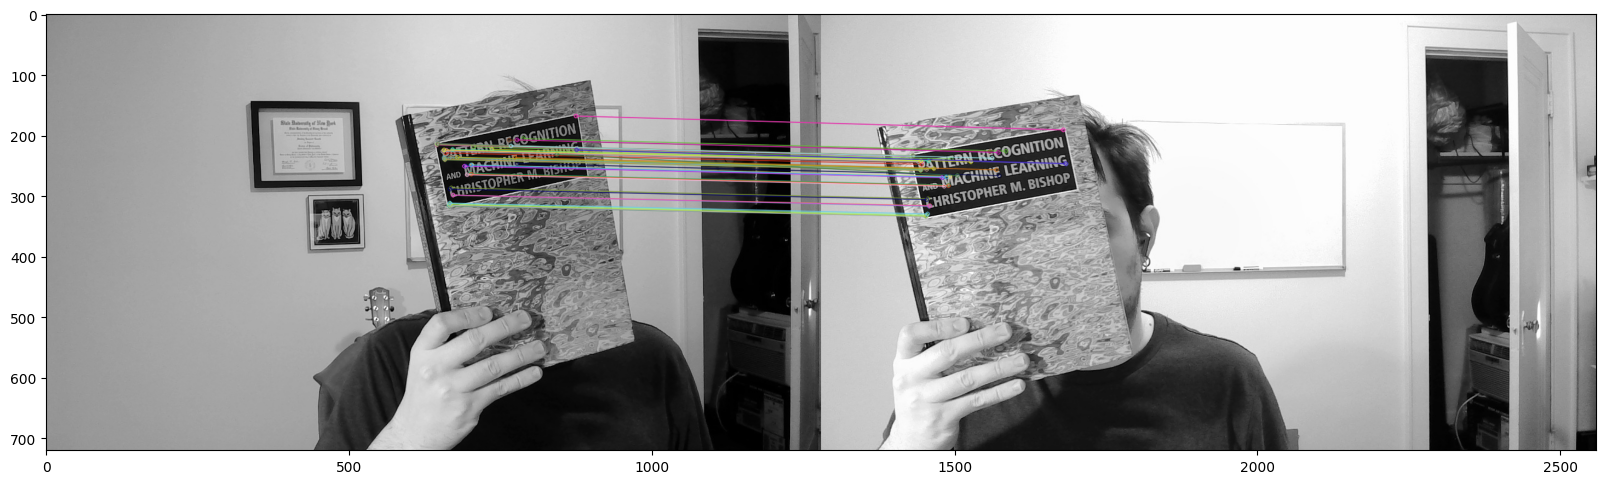

In [89]:
img_matches = cv.drawMatches(
    img1=img_l,
    keypoints1=kp_l,
    img2=img_r,
    keypoints2=kp_r,
    matches1to2=matches[:52],
    outImg=None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

fig = plt.figure(figsize=(20,10))
plt.imshow(img_matches)
plt.show()

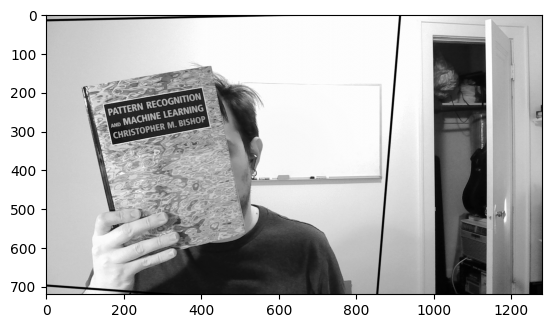

In [90]:
# Filter down to some pretty good matches
good = [
    m for m in matches if m.distance < 20
]
if len(good) < 10:
    raise ValueError(f"Not enough good matches (only found {len(good)})")

# Extract the matched point coordinates in each image
src_pts = np.float32([ kp_l[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_r[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography
M, mask = cv.findHomography(srcPoints=src_pts, dstPoints=dst_pts, method=cv.RANSAC, ransacReprojThreshold=0.1)
matchesMask = mask.ravel().tolist() # tells which matches are inliers or outliers

# Draw, in the right image, quadrilateral where the left image would be mapped to 
h,w = img_l.shape
pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts, M)

img2 = cv.polylines(img_r, [np.int32(dst)], True, 0, 3, cv.LINE_AA)

plt.imshow(img2, 'gray')
plt.show()

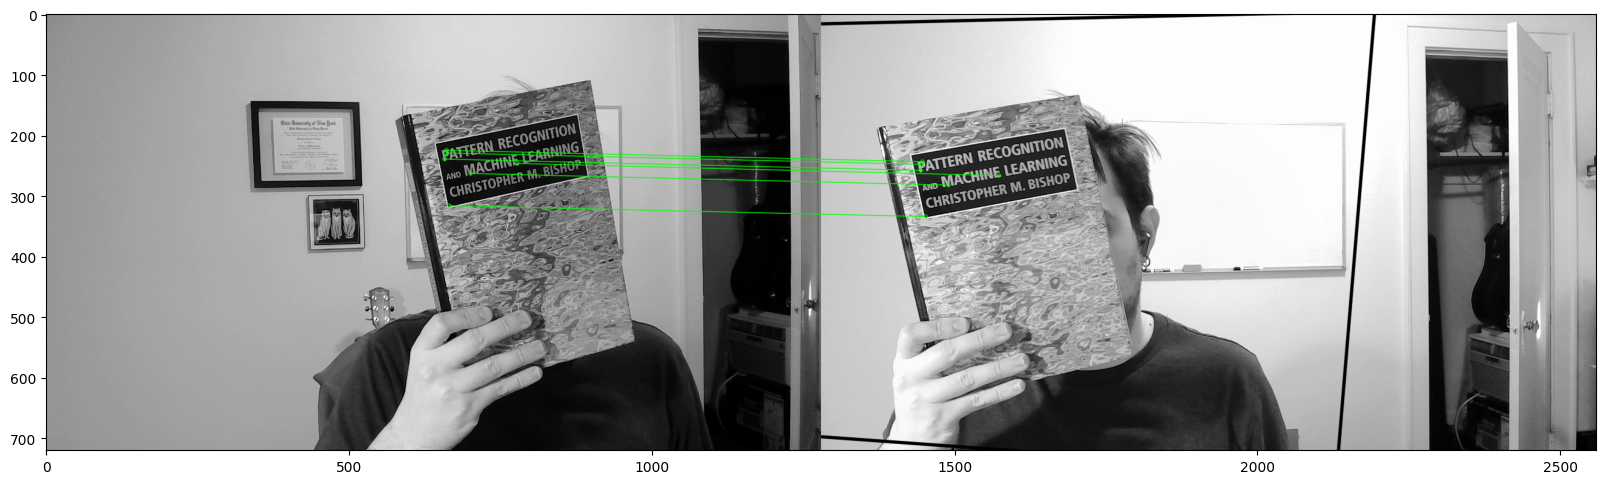

In [91]:
# Draw the matches with only inliers highlighted
draw_params = dict(
    matchColor=(0,255,0),
    singlePointColor=None,
    matchesMask=matchesMask,
    flags=2,
)
img3 = cv.drawMatches(img_l, kp_l, img_r, kp_r, good, None, **draw_params)

plt.figure(figsize=(20,10))
plt.imshow(img3, 'gray')
plt.show()

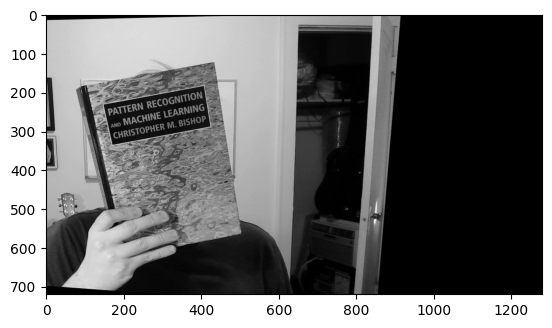

In [92]:
# Warp the left image
hr, wr = img_r.shape[:2]
img_warped = cv.warpPerspective(img_l, M, (wr, hr))
plt.imshow(img_warped, 'gray')
plt.show()

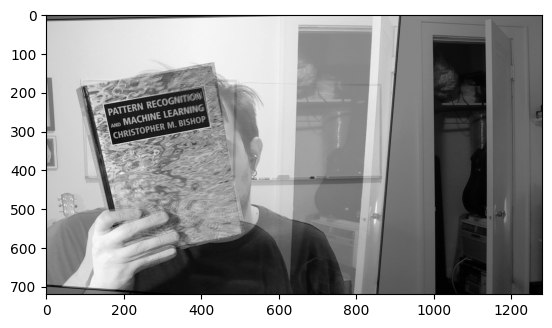

In [93]:
# Overlay the warped left image with the right image
overlay = cv.addWeighted(img_r, 0.5, img_warped, 0.5, 0)
plt.imshow(overlay, 'gray')
plt.show()